# 🏀 NBA Team Points Prediction Model 
📈 Embedding Model Testing 
---
🙋 **authors**: szymond44, gwiazdan  
📆 **date**: 21-07-2025  


In [2]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

In [3]:
%load_ext autoreload
%autoreload 2
from data.api_fetcher import ApiFetcher

In [4]:
api = ApiFetcher(starting_year=2014, ending_year=2025)
df = api.get_dataframe(numeric=False, date=True, time_coeff=False, ids=True)

In [5]:
df1 = df.copy()
cols_to_drop = [col for col in ['home_team', 'away_team'] if col in df1.columns]
df1.drop(cols_to_drop, axis=1, inplace=True)

In [6]:
def prep_df(df1, target_cols=['home_pts', 'away_pts'], scaler=None):
    team_id_cols = ['home_team_id', 'away_team_id']
    exclude_cols = target_cols + team_id_cols + ['date', 'home_team', 'away_team']
    numeric_cols = [col for col in df1.columns if col not in exclude_cols]


    X_numeric_raw = df1[numeric_cols].values
    X_team_ids = df1[team_id_cols].astype(int).values
    y = df1[target_cols].values 
    if scaler is None:
        scaler = StandardScaler()
        X_numeric = scaler.fit_transform(X_numeric_raw)
    else:
        X_numeric = scaler.transform(X_numeric_raw)

    return X_numeric, X_team_ids, y, scaler, numeric_cols

📄 **Model Concept**  
The goal of this model is to learn adaptive vector representations (embeddings) for each NBA team based on their performance statistics. These embeddings are trained jointly with the model and capture latent characteristics of each team. The model uses embeddings to predict the points scored by the home and away teams in a game.

In [7]:
class TeamEmbeddingNN(nn.Module):
    def __init__(self, num_teams, embedding_dim, num_numeric_features):
        super(TeamEmbeddingNN, self).__init__()
        
        # Embedding layers for home and away teams
        self.home_embedding = nn.Embedding(num_teams, embedding_dim)
        self.away_embedding = nn.Embedding(num_teams, embedding_dim)
        
        # Input layer size = numeric features + 2 embeddings concatenated
        input_size = num_numeric_features + embedding_dim * 2
        
        # Hidden layers
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        
        # Output layer (predict home_pts and away_pts)
        self.out = nn.Linear(32, 2)
        
    def forward(self, numeric_features, team_ids):
        
        home_emb = self.home_embedding(team_ids[:, 0])
        away_emb = self.away_embedding(team_ids[:, 1])
        
        # Concatenate embeddings with numeric features
        x = torch.cat([numeric_features, home_emb, away_emb], dim=1)
        
        # Forward pass through hidden layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Output predicted points
        out = self.out(x)
        return out



🔄  **Model Training**  
We train the model multiple times (20 runs) to evaluate its stability and performance variability. Each run involves training the model from scratch and evaluating it on a test set. We collect the test Mean Squared Error (MSE) from each run to analyze the distribution of errors.

In [11]:
df_sorted = df1.sort_values("date")
train_df, val_df, test_df = np.split(
    df_sorted, 
    [int(0.7*len(df_sorted)), int(0.85*len(df_sorted))]
)

X_train_num, X_train_ids, y_train, scaler, numeric_cols = prep_df(train_df)
X_val_num, X_val_ids, y_val, _, _ = prep_df(val_df, scaler=scaler)
X_test_num, X_test_ids, y_test, _, _ = prep_df(test_df, scaler=scaler)

class NBAEmbeddingDataset(Dataset):
    def __init__(self, X_numeric, X_team_ids, y):
        self.X_numeric = torch.tensor(X_numeric, dtype=torch.float32)
        self.X_team_ids = torch.tensor(X_team_ids, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X_numeric[idx], self.X_team_ids[idx], self.y[idx]

train_dataset = NBAEmbeddingDataset(X_train_num, X_train_ids, y_train)
val_dataset = NBAEmbeddingDataset(X_val_num, X_val_ids, y_val)
test_dataset = NBAEmbeddingDataset(X_test_num, X_test_ids, y_test)

num_teams = df1['home_team_id'].nunique()
embedding_dim = 8
num_numeric_features = X_train_num.shape[1]

def train_and_evaluate():
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = TeamEmbeddingNN(num_teams, embedding_dim, num_numeric_features)

    criterion = nn.MSELoss()
    learning_rate = 0.009187
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    num_epochs = 250

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss_epoch = 0
        for X_num_batch, X_ids_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_num_batch, X_ids_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss_epoch += loss.item() * X_num_batch.size(0)
        train_loss_epoch /= len(train_loader.dataset)
        train_losses.append(train_loss_epoch)

        model.eval()
        val_loss_epoch = 0
        with torch.no_grad():
            for X_num_batch, X_ids_batch, y_batch in val_loader:
                outputs = model(X_num_batch, X_ids_batch)
                loss = criterion(outputs, y_batch)
                val_loss_epoch += loss.item() * X_num_batch.size(0)
        val_loss_epoch /= len(val_loader.dataset)
        val_losses.append(val_loss_epoch)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_num_batch, X_ids_batch, y_batch in test_loader:
            outputs = model(X_num_batch, X_ids_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_num_batch.size(0)
    
    home_embeddings = model.home_embedding.weight.detach().cpu().numpy()
    away_embeddings = model.away_embedding.weight.detach().cpu().numpy()

    
    return test_loss / len(test_loader.dataset), model, home_embeddings, away_embeddings


N = 1
results = [train_and_evaluate() for _ in range(N)]

c:\Users\szymo\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [12]:
test_losses = [r[0] for r in results]
models = [r[1] for r in results]
home_embeddings_list = [r[2] for r in results]
away_embeddings_list = [r[3] for r in results]

print(f"Average Test MSE: {np.mean(test_losses):.4f} ± {np.std(test_losses):.4f}")
print(f"Minimal Test MSE: {np.min(test_losses)}")
best_model = models[np.argmin(test_losses)]
average_model = models[np.argsort(test_losses)[N//2]]
median_idx = np.argsort(test_losses)[N // 2]
average_model = models[median_idx]
average_embeddings_home = home_embeddings_list[median_idx]
average_embeddings_away = away_embeddings_list[median_idx]

print(f"Minimal error std: {np.sqrt(np.min(test_losses))}")
print(f"Average error std: {np.sqrt(np.average(test_losses))}")

Average Test MSE: 14.8069 ± 0.0000
Minimal Test MSE: 14.806922488474955
Minimal error std: 3.8479764147503497
Average error std: 3.8479764147503497


In [15]:
class EmbeddingFetcher:
    def __init__(self, home_embeddings, away_embeddings):
        self.home_embeddings = home_embeddings
        self.away_embeddings = away_embeddings

    def get_home_embedding(self, team_id):
        return self.home_embeddings[team_id]

    def get_away_embedding(self, team_id):
        return self.away_embeddings[team_id]

    def get_all_home_embeddings(self):
        return self.home_embeddings

    def get_all_away_embeddings(self):
        return self.away_embeddings


In [16]:
average_home_embeddings = home_embeddings_list[median_idx]
average_away_embeddings = away_embeddings_list[median_idx]

fetcher = EmbeddingFetcher(average_home_embeddings, average_away_embeddings)
team_id = 5
print("\nHome embedding for team 5:", fetcher.get_home_embedding(team_id))
print("\nAway embedding for team 5:", fetcher.get_away_embedding(team_id))

print("\nAll home embeddings shape:", fetcher.get_all_home_embeddings().shape)
print("All away embeddings shape:", fetcher.get_all_away_embeddings().shape)



Home embedding for team 5: [-1.2377415  -0.0260021   1.459951   -0.05860002 -0.55239844 -1.8509934
  0.18402612 -0.22666268]

Away embedding for team 5: [ 0.24408998  0.82879287  1.646302    2.4544282  -0.28758845 -0.36612493
  1.7326348  -0.17825991]

All home embeddings shape: (31, 8)
All away embeddings shape: (31, 8)


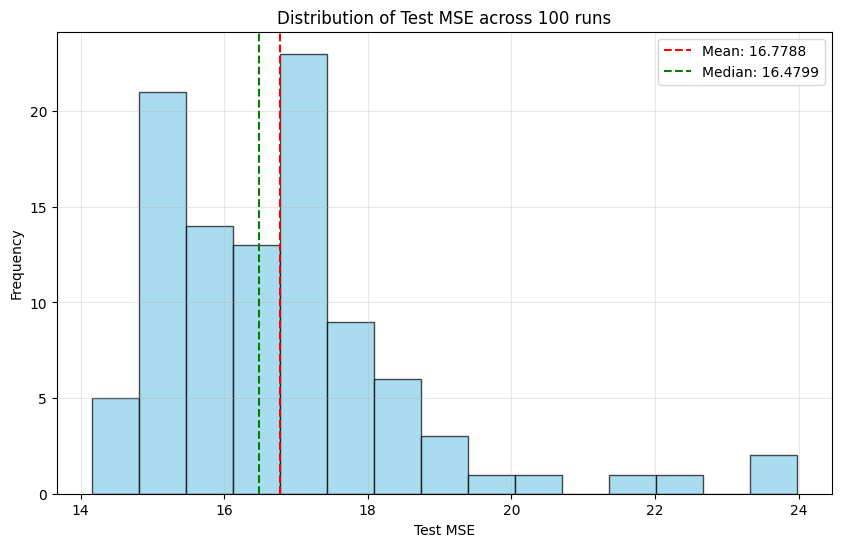

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(test_losses, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Test MSE')
plt.ylabel('Frequency')
plt.title('Distribution of Test MSE across 100 runs')
plt.axvline(np.mean(test_losses), color='red', linestyle='--', label=f'Mean: {np.mean(test_losses):.4f}')
plt.axvline(np.median(test_losses), color='green', linestyle='--', label=f'Median: {np.median(test_losses):.4f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

✏️ **Conclusions**  
The graphic above shows that the model's performance is relatively stable across multiple runs, with most test MSE values clustering around the mean. However, there are a few outliers with significantly higher or lower MSE values, indicating that the model's performance can vary depending on the initialization and training process. The overall result is satisfactory as it will be used as a submodel in a more complex ensemble model.